In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Helper_Functions import Generate_Features, Quality_Evaluation
from skimage.io import imread
from skimage.transform import rescale
from sklearn.ensemble import RandomForestClassifier
from skimage.segmentation import random_walker
from multiprocessing import cpu_count
from skimage.morphology import opening, disk
import os
from sklearn.externals import joblib
from scipy.ndimage.morphology import binary_fill_holes


In [13]:
def RF_Post_Processed(Image,mask_Ego_Vehicle,mask_out_of_roi,thres1=0.9,thres2=0.5,sky_height=50,PP=True):
    nx,ny=Image.shape[0:2]
    Test_Features=np.reshape(Generate_Features(Image),[54,nx*ny]).T
    Prediction = RF.predict_proba(Test_Features)
    Prediction = Prediction.reshape([nx,ny,2])
    if PP==False:
        return Prediction[:,:,1]>0.5
    else:
        Non_Road_Seeds = Prediction[:,:,0]>thres1
        Sky=np.zeros(Prediction[:,:,0].shape, dtype=bool)
        Sky[0:sky_height,:]=True
        Non_Road_Seeds=(Non_Road_Seeds|Sky) 
        Non_Road_Seeds[mask_Ego_Vehicle]=False
        selem = disk(3)
        Non_Road_Seeds=opening(Non_Road_Seeds,selem)

        
        plt.figure(figsize=(5,5))
        plt.axis("off")
        plt.imshow(Prediction[:,:,0])
        plt.title("Non-Road Seed Probability")
        plt.show()
        
        plt.figure(figsize=(5,5))
        plt.axis("off")
        plt.imshow(Non_Road_Seeds)
        plt.title("Non-Road Seeds")
        plt.show()
        
        Road_Seeds=Prediction[:,:,1]>thres2
        Road_Seeds[0:110,:]=False
        Road_Seeds=Road_Seeds|mask_Ego_Vehicle
        selem = disk(7)
        Road_Seeds=opening(Road_Seeds,selem)
        labels=np.zeros(Prediction[:,:,0].shape, dtype=int)

        labels[Non_Road_Seeds]=1
        labels[Road_Seeds]=2
  
        plt.figure(figsize=(5,5))
        plt.axis("off")
        plt.imshow(Prediction[:,:,1])
        plt.title("Road Seed Probability")
        plt.show()
        
          
        plt.figure(figsize=(5,5))
        plt.axis("off")
        plt.imshow(Road_Seeds)
        plt.title("Road Seeds")
        plt.show()
        
        Segmentation=random_walker(Image, labels, beta=250, multichannel=True)
        Segmentation2=random_walker(Image, labels, beta=250,return_full_prob=True ,multichannel=True)
        
        plt.figure(figsize=(5,5))
        plt.axis("off")
        plt.imshow(Segmentation2[1,:,:])
        plt.title("Road Probability by RWA")
        plt.show()
        
        Result=np.zeros([nx,ny], dtype=bool)
        Result[Segmentation==2]=True
        Result=binary_fill_holes(Result)
        Result[mask_Ego_Vehicle]=False
        Result[mask_out_of_roi]=False
        return Result

In [3]:
def Get_Image_and_Ground_Truth(GT_path,Im_path):
    GT=[]
    Im=[]
    for file in os.listdir(GT_path):
        if file.endswith("_gtFine_labelIds.png"):
            GT.append(file)


    Im=os.listdir(Im_path)

    GT=sorted(GT)
    Im=sorted(Im)
    return GT,Im

In [4]:
RF = joblib.load('RF_strasbourg_mxd20est256.pkl')
print("Random Forest Model Loaded")

Random Forest Model Loaded


In [5]:
#print(RF.feature_importances_)

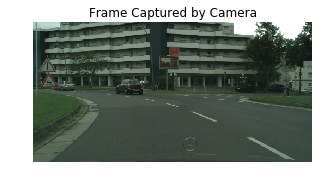

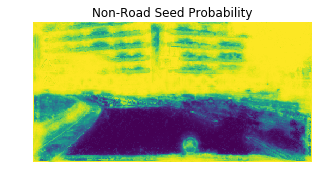

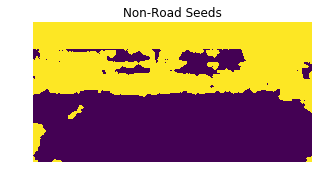

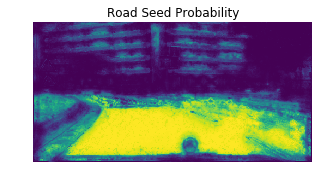

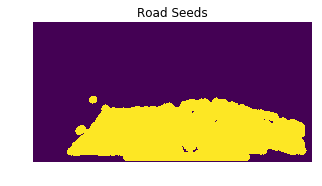

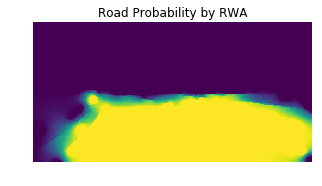

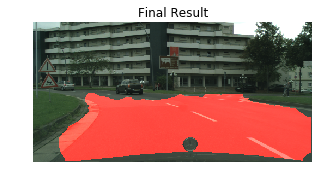

In [14]:
#"strasbourg"
towns=["aachen"]
Im_path="/home/thanos/Desktop/Project_ADAS_2017/CITYSCAPE/Images/train/"
GT_path="/home/thanos/Desktop/Project_ADAS_2017/CITYSCAPE/Ground_Truth/train/"

scale_factor=0.25

P=[]
C=[]
Q=[]

P2=[]
C2=[]
Q2=[]
for town in towns:
    Im_path_town=Im_path+town
    GT_path_town=GT_path+town
    
    GT=[]
    Im=[]
    GT,Im=Get_Image_and_Ground_Truth(GT_path_town,Im_path_town)
  
    steps=1
    for i in range(0,steps):   
        Image=imread(Im_path+town+"/"+Im[i])
        labels=imread(GT_path+town+"/"+GT[i])

        Image=rescale(Image,scale_factor,mode='reflect')

        labels=rescale(labels,scale_factor,mode='reflect', preserve_range=True)

        nx,ny=Image.shape[0:2]
        mask_out_of_roi = labels==3
        mask_Ego_Vehicle = labels==1
        Ground_Truth=labels==7

        plt.figure(figsize=(5,5))
        plt.axis("off")
        plt.imshow(Image)
        plt.title("Frame Captured by Camera")
        plt.show()

        Result1=RF_Post_Processed(Image,mask_Ego_Vehicle,mask_out_of_roi,thres1=0.9,thres2=0.5,sky_height=50,PP=True)

        Im1=Image.copy()
       
        Im1[:,:,0][Result1]=1
   

        plt.figure(figsize=(5,5))
        plt.axis("off")
        plt.imshow(Im1)
        plt.title("Final Result")
        plt.show()

   